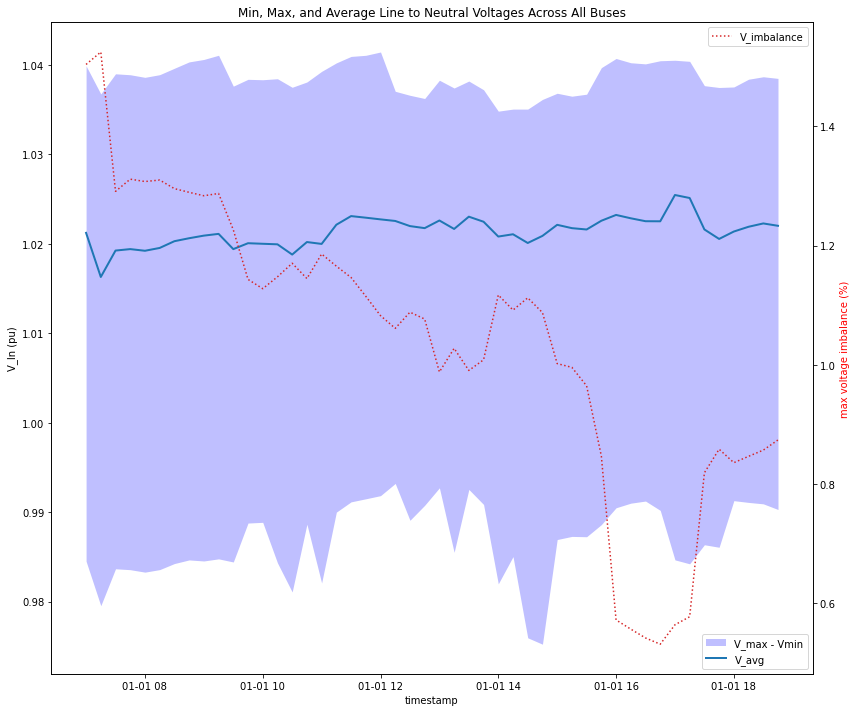

In [1]:
# 1-week QSTS
import pandas as pd
from pathlib import Path
import PowerSystemClasses as ps
import opendssdirect as dss
import numpy as np

def QSTS():
    Dnetwork = ps.DistNetwork()

    components = {'nodes': Path('..', 'network-data', 'nodes.csv'),
              'line_geos': Path('..', 'network-data', 'LineGeometry.csv'),
              'wire_data': Path('..', 'network-data', 'WireData.csv'),
              'CN_data': Path('..', 'network-data', 'CNData.csv'),
              'lines': Path('..', 'network-data', 'lines.csv'),
              'loads': Path('..', 'network-data', 'loads.csv'),
              'xfmrs': Path('..', 'network-data', 'xfmrs.csv'),
              'regs': Path('..', 'network-data', 'regs.csv'),
              'PV': Path('..', 'network-data', 'PV.csv'),
              'circuit': Path('..', 'network-data', 'circuit.csv')}
    
    Dnetwork.add_circuit(components['circuit'])
    Dnetwork.add_nodes(components['nodes'])
    Dnetwork.add_line_geoms(components['line_geos'])
    Dnetwork.add_wiredata(components['wire_data'])
    Dnetwork.add_CNdata(components['CN_data'])
    Dnetwork.add_lines(components['lines'])
    Dnetwork.add_xfmrs(components['xfmrs'])

    Dnetwork.calc_Vbases()

    Dnetwork.add_pvsystems(components['PV'])
    Dnetwork.add_loads(components['loads'])
    Dnetwork.add_regulators(components['regs'])

    Dnetwork.calc_electrical_distance()
        
    Dnetwork.check_floating_lines()

    loads_path = Path('..', 'network-data', 'load_profiles.csv')
    load_profiles = pd.read_csv(loads_path, parse_dates=['datetime'],index_col='datetime')
    load_profiles = load_profiles.resample('15min').interpolate()
    load_profiles = load_profiles.iloc[28:76,]
    Dnetwork.assign_random_load_profile(load_profiles)

    ghi_path = Path('..', 'network-data', 'boulder_ghi.csv')
    ghi_profile = pd.read_csv(ghi_path, parse_dates=['datetime'],index_col='datetime')
    ghi_profile = ghi_profile.resample('15min').interpolate()
    ghi_profile = ghi_profile.loc[load_profiles.index[0]:load_profiles.index[-1]]
    Dnetwork.assign_all_irradiance(ghi_profile.squeeze('columns'))

    xy_curves = pd.Series({
        'cont': np.array([[0.1, 1],[0.95, 1],[1.05,-1],[1.9, -1]]),
        'deadband': np.array([[0.1, 1],[0.95, 1],[0.98, 0],[1.02,0],[1.05,-1],[1.9, -1]])
        })
    Dnetwork.xy_curves = xy_curves

    return Dnetwork, load_profiles

Dnetwork, load_profiles = QSTS()

#run the time series simulation using the convential regulator controls and inverter controls

def QSTS_distr_control(Dnetwork, load_profiles):
    Dnetwork.compile_DSS(opt=False)
    Dnetwork.run_DSS_load_profile(load_profiles.index)
    return Dnetwork

distr_crl = QSTS_distr_control(Dnetwork, load_profiles)
distr_crl.plt_ts_voltages()

['edit transformer=xfmr_0src_noden0 tap=', 'edit transformer.xfmr_1n16 tap=', 'edit transformer.xfmr_2n16 tap=', 'edit transformer.xfmr_3n16 tap=', 'edit transformer.xfmr_1n18 tap=', 'edit transformer.xfmr_2n18 tap=', 'edit transformer.xfmr_3n18 tap=', 'edit PVsystem.pv_n2 kvar=', 'edit PVsystem.pv_n17 kvar=', 'edit PVsystem.pv_n23 kvar=', 'edit PVsystem.pv_n27 kvar=', 'edit PVsystem.pv_n32 kvar=', 'edit PVsystem.pv_n38 kvar=']
2022-01-01 07:00:00
starting optimization
[12.73680243 -0.18410728 10.8486449  -0.23630899  3.99084549 -1.76456793
  5.24335874  0.32106049 72.88942891 53.98188357  0.11945748  5.9140153
 16.44804593]
1.4570923152441215
2022-01-01 07:15:00
starting optimization
[ -0.67243805  -8.08212163   2.36002042  -1.4396118   -3.51943667
   0.65868168   4.16533496   0.24754295 123.23355894 130.08634638
  18.22791394   4.87968612  17.23042347]
1.4463935680831237
2022-01-01 07:30:00
starting optimization
[-14.58920482  -6.91364666   4.67815923   0.16158853  -2.28590935
   1.4

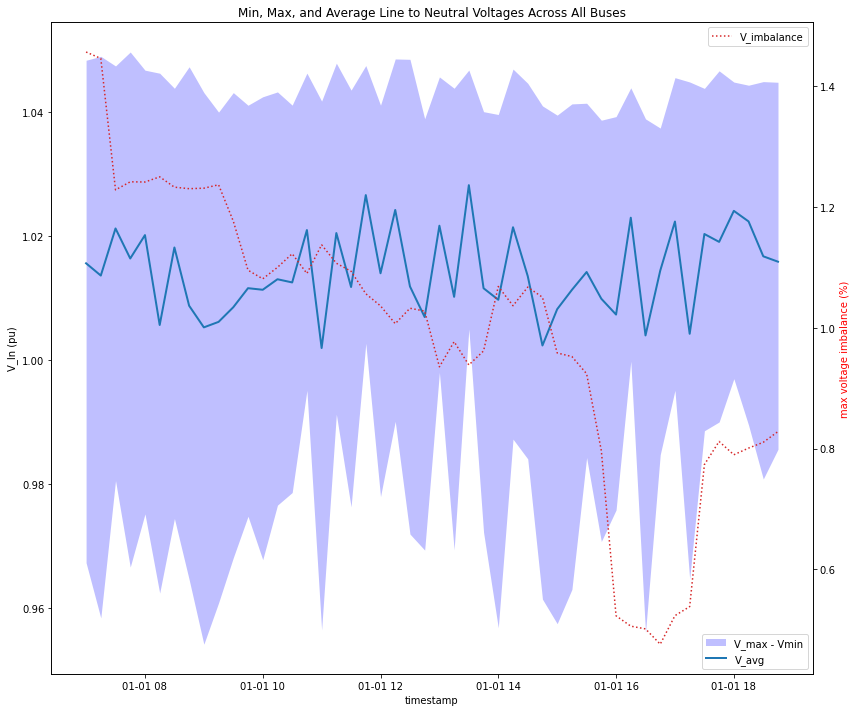

In [2]:
#Run using the differential evolution algorithm to optimize tap settings and PV inverter kVAr values.

def QSTS_central_control(Dnetwork, load_profiles):
    Dnetwork.compile_DSS(opt=True)
    Dnetwork.run_DSS_load_profile_opt(load_profiles.index)
    return Dnetwork

central_crl = QSTS_central_control(Dnetwork, load_profiles)
central_crl.plt_ts_voltages()